In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2 
from sklearn.metrics import mean_absolute_percentage_error as mape
import shap, datetime, warnings
from great_tables import GT, md, html, style, loc
warnings.filterwarnings('ignore')

In [139]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))
predictions = pd.read_pickle('../../output/predictions_overall.pkl')

In [140]:
predictions

,date,ticker,Actual,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_9,...,Predicted (NeuralNet) (all),Predicted (LightGBM) (time_only),Predicted (LightGBM) (sentiment_only),Predicted (LightGBM) (self_finance_only),Predicted (LightGBM) (finance_only),Predicted (LightGBM) (finance_time),Predicted (LightGBM) (all),Predicted (LightGBM) (all_tuned),Predicted (LightGBM) (all_tuned_retrained),Predicted Baseline
0,2023-12-04 12:45:00,AAL,1293240,0,0,1,0,0,0,0,...,1.062676e+06,2.166145e+05,853039.208070,1.466402e+06,1.467144e+06,1.444167e+06,1.398818e+06,1.273039e+06,1.385569e+06,778534.8
1,2023-12-04 12:45:00,ALGT,1447,0,0,1,0,0,0,0,...,9.692740e+03,2.166145e+05,117560.899842,3.084344e+03,2.405521e+03,5.587949e+03,3.406106e+03,1.775199e+03,3.620900e+03,3024.0
2,2023-12-04 12:45:00,ALK,587333,0,0,1,0,0,0,0,...,1.615639e+05,2.166145e+05,657044.943388,3.758347e+05,4.132884e+05,3.735391e+05,3.653477e+05,3.965052e+05,3.878293e+05,27429.2
3,2023-12-04 12:45:00,DAL,94989,0,0,1,0,0,0,0,...,1.294410e+05,2.166145e+05,276890.669042,1.747686e+05,1.862419e+05,1.748006e+05,1.693648e+05,1.612089e+05,1.758026e+05,142879.8
4,2023-12-04 12:45:00,JBLU,273608,0,0,1,0,0,0,0,...,3.706713e+05,2.166145e+05,830606.119024,5.119678e+05,5.256118e+05,4.896124e+05,4.796478e+05,4.580689e+05,4.958197e+05,372734.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67553,2025-05-30 15:45:00,ALK,440444,0,0,0,0,0,1,0,...,7.893551e+05,1.063072e+06,205925.448478,3.283563e+05,3.981022e+05,5.539017e+05,5.802983e+05,5.299487e+05,4.925179e+05,353491.8
67554,2025-05-30 15:45:00,DAL,1245698,0,0,0,0,0,1,0,...,9.146906e+05,1.063072e+06,376416.982429,1.007004e+06,1.023123e+06,1.061786e+06,1.058074e+06,1.242038e+06,1.076072e+06,1506096.4
67555,2025-05-30 15:45:00,JBLU,8400782,0,0,0,0,0,1,0,...,4.472642e+06,1.063072e+06,285688.984920,3.415540e+06,3.235173e+06,3.590649e+06,3.451630e+06,3.598861e+06,3.577430e+06,3093992.0
67556,2025-05-30 15:45:00,LUV,2026886,0,0,0,0,0,1,0,...,2.007167e+06,1.063072e+06,316754.581946,1.256809e+06,1.268855e+06,1.217692e+06,1.229052e+06,1.449506e+06,1.282050e+06,1424504.4


In [141]:
price = df[['date', 'ticker', 'Last']].copy()
predictions = pd.merge(predictions, price, on=['date', 'ticker'], how='left')

In [142]:
predictions['Predicted (LightGBM) (all_tuned_retrained)'] = np.where(predictions['Predicted (LightGBM) (all_tuned_retrained)'] < 0, 0, predictions['Predicted (LightGBM) (all_tuned_retrained)'])

In [143]:
vwap_data = predictions[['date','ticker','Actual','Last','Predicted Baseline','Predicted (LightGBM) (all_tuned_retrained)']].copy()
vwap_data['$ Volume'] = vwap_data['Actual'] * vwap_data['Last']
vwap_data['day'] = vwap_data['date'].dt.date
vwap_data.drop(columns=['date'], inplace=True)

In [144]:
portfolio = vwap_data.groupby(['day', 'ticker']).sum().reset_index()
portfolio['1% of Turnover'] = portfolio['$ Volume'] * 0.01

In [145]:
vwap_data_agg = vwap_data.groupby(['day', 'ticker']).sum().reset_index()
vwap_data_agg = vwap_data_agg[['day', 'ticker', 'Actual','Predicted Baseline','Predicted (LightGBM) (all_tuned_retrained)']]
vwap_data_agg.rename(columns={
    'Actual': 'Tot. Volume',
    'Predicted Baseline': 'Tot. Predicted (Baseline)',
    'Predicted (LightGBM) (all_tuned_retrained)': 'Tot. Predicted (Best)'
}, inplace=True)
vwap_data = pd.merge(vwap_data, vwap_data_agg, on=['day', 'ticker'], how='left')

vwap_data['weight (Actual)']   = vwap_data['Actual'] / vwap_data['Tot. Volume']
vwap_data['weight (Baseline)'] = vwap_data['Predicted Baseline'] / vwap_data['Tot. Predicted (Baseline)']
vwap_data['weight (Best)']     = vwap_data['Predicted (LightGBM) (all_tuned_retrained)'] / vwap_data['Tot. Predicted (Best)']

vwap_data['weighted price (Actual)']   = vwap_data['Last'] * vwap_data['weight (Actual)']
vwap_data['weighted price (Baseline)'] = vwap_data['Last'] * vwap_data['weight (Baseline)']
vwap_data['weighted price (Best)']     = vwap_data['Last'] * vwap_data['weight (Best)']

In [146]:
vwap_data = vwap_data[['day', 'ticker', 'weighted price (Actual)', 'weighted price (Baseline)', 'weighted price (Best)']]
vwap_data = vwap_data.groupby(['day', 'ticker']).sum().reset_index()
vwap_data.rename(columns={
    'weighted price (Actual)': 'VWAP',
    'weighted price (Baseline)': 'VWAP (Baseline)',
    'weighted price (Best)': 'VWAP (Best)'
}, inplace=True)

In [147]:
vwap_data['VWAP Error (Baseline)'] = np.abs(vwap_data['VWAP'] - vwap_data['VWAP (Baseline)']) / vwap_data['VWAP'] * 100 * 100 # basis points
vwap_data['VWAP Error (Best)']     = np.abs(vwap_data['VWAP'] - vwap_data['VWAP (Best)'])     / vwap_data['VWAP'] * 100 * 100 # basis points

In [148]:
vwap_data = vwap_data[['ticker','VWAP Error (Baseline)','VWAP Error (Best)']].groupby('ticker').mean()
vwap_data['Improvement'] = ((vwap_data['VWAP Error (Best)'] / vwap_data['VWAP Error (Baseline)']) - 1) * 100
vwap_data

,VWAP Error (Baseline),VWAP Error (Best),Improvement
ticker,,,
AAL,11.084991,7.374818,-33.470238
ALGT,18.348317,16.318264,-11.063976
ALK,11.170914,8.070972,-27.750123
DAL,11.215983,5.997430,-46.527828
JBLU,18.122388,12.481346,-31.127473
LUV,9.894660,6.490618,-34.402818
UAL,15.544927,9.826889,-36.783950


In [149]:
vwap_data.describe()

,VWAP Error (Baseline),VWAP Error (Best),Improvement
count,7.000000,7.000000,7.000000
mean,13.626026,9.508620,-31.589487
std,3.615138,3.727519,10.784551
min,9.894660,5.997430,-46.527828
25%,11.127953,6.932718,-35.593384
50%,11.215983,8.070972,-33.470238
75%,16.833657,11.154118,-29.438798
max,18.348317,16.318264,-11.063976


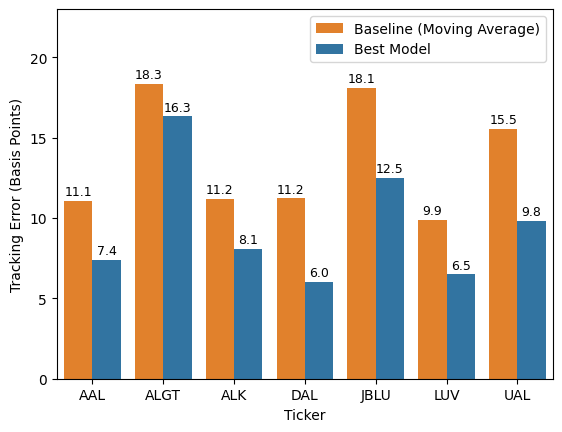

In [150]:
plot_data = vwap_data.stack().reset_index()
plot_data = plot_data[plot_data['level_1']!='Improvement']
plot_data['level_1'] = plot_data['level_1'].str.replace('VWAP Error (Baseline)','Baseline (Moving Average)').replace('VWAP Error (Best)','Best Model')

# Swap the colors of the bars by specifying the palette order
palette = {
    'Baseline (Moving Average)': sns.color_palette()[1],  # Use the second color for Baseline
    'Best Model': sns.color_palette()[0]                 # Use the first color for Best Model
}
ax = sns.barplot(data=plot_data, x='ticker', y=0, hue='level_1', palette=palette)
plt.ylim(0,23)
plt.legend(title='')
plt.xlabel('Ticker')
plt.ylabel('Tracking Error (Basis Points)')

# Add data labels
for p in ax.patches:
    
    height = p.get_height()
    if not np.isnan(height) and height > 0:
        ax.annotate(f'{height:.1f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=9, color='black',
                    xytext=(0, 2),
                    textcoords='offset points')

plt.savefig('../../output/vwap_compare.pdf')

In [ ]:
# VWAP error over time

In [151]:
portfolio

,day,ticker,Actual,Last,Predicted Baseline,Predicted (LightGBM) (all_tuned_retrained),$ Volume,1% of Turnover
0,2023-12-04,AAL,17598756,172.958405,14652707.2,1.838870e+07,2.343268e+08,2.343268e+06
1,2023-12-04,ALGT,87461,954.496094,87254.6,9.866597e+04,6.430486e+06,6.430486e+04
2,2023-12-04,ALK,7575095,440.104706,871959.8,5.920561e+06,2.570389e+08,2.570389e+06
3,2023-12-04,DAL,2231543,496.627808,3277999.2,2.793705e+06,8.519836e+07,8.519836e+05
4,2023-12-04,JBLU,6317349,63.009399,7136817.8,7.980021e+06,3.060666e+07,3.060666e+05
...,...,...,...,...,...,...,...,...
2606,2025-05-30,ALK,1654853,1329.640015,1816027.8,1.739838e+06,8.455661e+07,8.455661e+05
2607,2025-05-30,DAL,5486818,1255.502441,6702640.4,5.501810e+06,2.652397e+08,2.652397e+06
2608,2025-05-30,JBLU,30301587,133.649506,25635536.6,2.720048e+07,1.551656e+08,1.551656e+06
2609,2025-05-30,LUV,7274456,867.630005,8878496.8,6.928393e+06,2.428213e+08,2.428213e+06
